In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns



sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
import helper

sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
import plot_helpers


In [3]:
## Load training data

def load_data(train_val='train'):
    assert isinstance(train_val, str) and train_val in ['train', 'val'], "train_val should be a string and must be either 'train' or 'val'"
    
    monthlist = ['DEC17','JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    path = '/net/helium/atmosdyn/freimax/data_msc/IFS-18/cyclones/data_random_forest'

    list_df_1month = []
    for month in monthlist:
        list_df_1month.append(pd.read_pickle(f'{path}/{month}/df_ifs_masked_{train_val}.pkl'))

    # Concatenate all dataframes in the list into a single dataframe
    print('Concatente all df to one')
    df = pd.concat(list_df_1month, ignore_index=True)

    # Cancel unallowed values (coolin rate positve)
    df[df['tmeltsi']>0] = 0
    df[df['tsubsi']>0] = 0
    df[df['tevr']>0] = 0

    return df

df_train = load_data('train')
df_val = load_data('val')
df_full = pd.concat([df_train, df_val], ignore_index=True)

Concatente all df to one
Concatente all df to one


In [4]:
## TSubSI
cols_target_features = ['tsubsi', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']
df_full_tsubsi = df_full[cols_target_features]

df_tsubsi = rf_functions.apply_domainfilter(df=df_full_tsubsi,
                                                water_type='SIWC',
                                                verbose=1,
                                                temp_filter=False,output_filter=False)

## Tmeltsi
cols_target_features = ['tmeltsi', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']  
df_full_tmeltsi = df_full[cols_target_features]

df_tmeltsi = rf_functions.apply_domainfilter(df=df_full_tmeltsi,
                                                 water_type='SIWC',
                                                 verbose=1,
                                                 temp_filter=True,
                                                 output_filter=False)

cols_target_features = ['tevr', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']
df_full_tevr = df_full[cols_target_features]

df_tevr = rf_functions.apply_domainfilter(df=df_full_tevr,
                                                water_type='RWC',
                                                verbose=1,
                                                temp_filter=False,output_filter=False)

Drop all points where SIWC == 0
Drop all points where SIWC == 0 and Temp < 0
Drop all points where RWC == 0


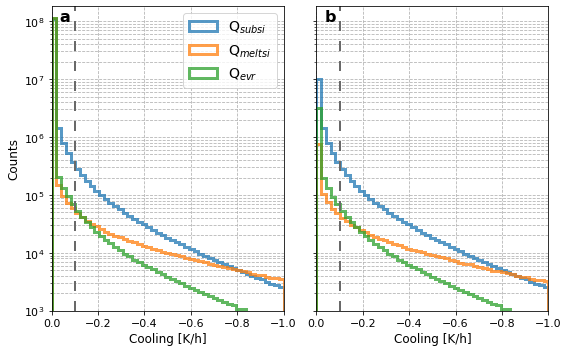

In [8]:
bins = np.linspace(-1, 0, 50)

# Plotting
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(8, 5), sharey=True)


data = [df_full, [df_tsubsi, df_tmeltsi, df_tevr]]

ax[0].hist(df_full['tsubsi'] , bins=bins, alpha=0.75, label=r'Q$_{subsi}$' , log=True, histtype='step', linewidth=3)
ax[0].hist(df_full['tmeltsi'], bins=bins, alpha=0.75, label=r'Q$_{meltsi}$', log=True, histtype='step', linewidth=3)
ax[0].hist(df_full['tevr']   , bins=bins, alpha=0.75, label=r'Q$_{evr}$'   , log=True, histtype='step', linewidth=3)

ax[1].hist(df_tsubsi['tsubsi']  , bins=bins, alpha=0.75, label=r'Q$_{subsi}$' , log=True, histtype='step', linewidth=3)
ax[1].hist(df_tmeltsi['tmeltsi'], bins=bins, alpha=0.75, label=r'Q$_{meltsi}$', log=True, histtype='step', linewidth=3)
ax[1].hist(df_tevr['tevr']      , bins=bins, alpha=0.75, label=r'Q$_{evr}$'   , log=True, histtype='step', linewidth=3)



for i in range(2):
    ax[i].set_xlabel('Cooling [K/h]', fontsize=12)
    ax[i].grid(True, which="both", ls="--", c='0.7')
    ax[i].set_xlim(-1,0)
    ax[i].invert_xaxis()
    ax[i].set_ylim(1e3,1.8e8)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].axvline(x=-0.1, linewidth=2, c='dimgrey', linestyle='--', dashes=(5,5))

ax[0].set_ylabel('Counts', fontsize=12)
ax[0].legend(fontsize=14)
# Add labels to each subplot
labels = ['a', 'b']
for col in range(2):
    label= labels[col]
    ax[col].text(0.035, 0.99, label, transform=ax[col].transAxes, 
    color='k', fontsize=16, fontweight='bold', va='top')

# Save the figure
plt.tight_layout()
plt.savefig('/home/freimax/msc_thesis/figures/thesis_msc/imbalance.png', dpi=100)

plt.show()

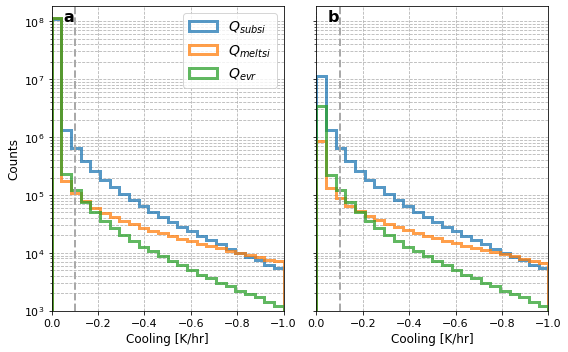

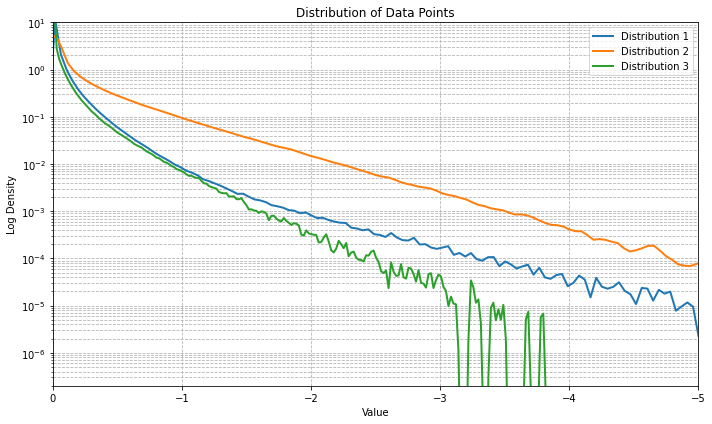

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(df_tsubsi['tsubsi'],   ax=ax, label='Distribution 1', log_scale=(False, True), linewidth=2, bw_adjust=1.75)
sns.kdeplot(df_tmeltsi['tmeltsi'], ax=ax, label='Distribution 2', log_scale=(False, True), linewidth=2, bw_adjust=1.75)
sns.kdeplot(df_tevr['tevr'],       ax=ax, label='Distribution 3', log_scale=(False, True), linewidth=2, bw_adjust=1.75)

# Aesthetics
ax.set_xlabel('Value')
ax.set_ylabel('Log Density')
ax.set_title('Distribution of Data Points')
ax.legend()
ax.grid(True, which="both", ls="--", c='0.7')

ax.set_xlim(-5,0.1)
ax.invert_xaxis()
ax.set_ylim(2e-7, 1e1)
# Save the figure
plt.tight_layout()
# plt.savefig('kdeplot.png', dpi=300)

plt.show()
